In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Libraiers

In [2]:
import torch 
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

### Transforming Data

In [3]:
trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,),(.5,))])

###  Downloading Train and test data

In [4]:
train_data=datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=trans)
test_data=datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=trans)
test_load=DataLoader(test_data,batch_size=1024,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5575790.05it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 146920.01it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1395805.57it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2846761.62it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [8]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [9]:
len(train_data)

60000

# Visualizing data

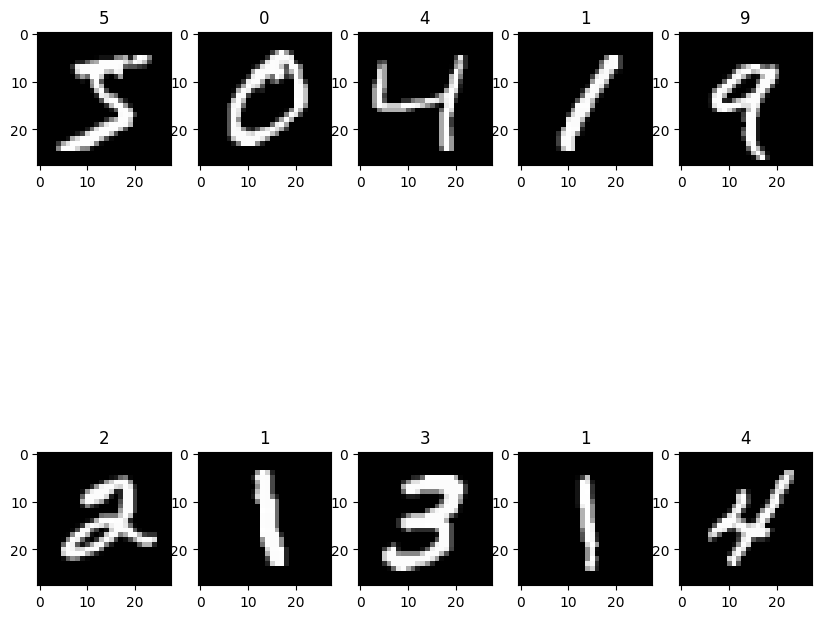

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(train_data[i][1])
    imshow(train_data.data[i],cmap='gray')

# Analyze data

In [11]:
print(train_data[0][0].shape)
lable_count=[]
from collections import Counter
for i in train_data:
    lable_count.append(i[1])
    

torch.Size([1, 28, 28])


In [12]:
lable_counter=Counter(lable_count)

### Checking Frequency of Each Class

In [13]:
lable_counter

Counter({1: 6742,
         7: 6265,
         3: 6131,
         2: 5958,
         9: 5949,
         0: 5923,
         6: 5918,
         8: 5851,
         4: 5842,
         5: 5421})

# Define Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report,confusion_matrix

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,64,3,1)
        self.conv2=nn.Conv2d(64,128,3,1)

        self.drop1=nn.Dropout(.25)
        self.drop2=nn.Dropout(.5)

        self.fc1=nn.Linear(18432,128)
        self.fc2=nn.Linear(128,10)
            
    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,2)
        x=self.drop1(x)
        x=torch.flatten(x,1)

        x=self.fc1(x)
        x=F.relu(x)
        x=self.drop2(x)
        x=self.fc2(x)

        output=F.log_softmax(x,dim=1)
        return output

# Hyperparameter and Early stopping

In [16]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
l_r=.001
batch_size=1024
epoch=3
patience=1

model=nn.DataParallel(Net())
optimizer=optim.Adam(model.parameters(),lr=l_r)
criterion=nn.CrossEntropyLoss()

In [18]:

model.to(device)

v_l_min=np.Inf
patience_count=0

# Train-val-Test split

In [19]:
from torch.utils.data.dataset import random_split

num_train=len(train_data)
num_valid= int(num_train*.2)
num_train-=num_valid

In [20]:
train,valid=random_split(train_data,[num_train,num_valid])

# Loading data

In [21]:
train_load=DataLoader(train,batch_size=32,shuffle=True)
valid_load=DataLoader(valid,batch_size=32,shuffle=True)

# Train Loop

In [22]:
from tqdm import tqdm
for i in range(epoch):
    train_loss=0
    valid_loss=0.0
    correct=0
    total=0
    
    model.train()
    for data,target in tqdm(train_load):
        data=data.to(device)
        target=target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
    model.eval()
    with torch.no_grad():
        for data,target in tqdm(valid_load):
            data=data.to(device)
            target=target.to(device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss+=loss.item()*data.size(0)
            pred=output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    print({len(train)})
    print({len(train_load.sampler)})    
    print(f" epoch {i}")
    print(f" ave. train loss {train_loss/len(train)}")
    print(f" ave. valid loss {valid_loss/len(valid)}")
    print(f"Accuracy {100*(correct/(len(valid)))}")
    
    if v_l_min >= valid_loss:
        torch.save(model.state_dict(),'model_cifar.pt')
        v_l_min=valid_loss
        patience_count=0
    else:
        patience_count+=1
        print(f'E S Count {patience_count}')
        if patience_count==patience:
            print('Early Stop')
            break
    
        

100%|██████████| 375/375 [00:02<00:00, 127.68it/s]


{48000}
{48000}
 epoch 0
 ave. train loss 0.20919997045506414
 ave. valid loss 0.05954029288748279
Accuracy 98.15833333333333


100%|██████████| 375/375 [00:02<00:00, 125.49it/s]


{48000}
{48000}
 epoch 1
 ave. train loss 0.094765281668903
 ave. valid loss 0.04753081976627194
Accuracy 98.50833333333333


100%|██████████| 375/375 [00:02<00:00, 127.98it/s]

{48000}
{48000}
 epoch 2
 ave. train loss 0.07251495169961224
 ave. valid loss 0.04495218497274861
Accuracy 98.71666666666667


In [23]:
from collections import defaultdict
res=defaultdict(int)
for i in range(len(pred)):
    if pred[i].item()==target[i].item():
        res[target[i].item()]+=1

# Loading model and Evaluate

In [24]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [25]:
from collections import defaultdict
correct_by_class=defaultdict(int)
class_frequency_target=Counter()
correct=0
total=0
test_loss=0
overall=0
y_true,y_predicted=[],[]
model.eval()
with torch.no_grad():
    for data,target in tqdm(test_load):
        data=data.to(device)
        target=target.to(device)
        output=model(data)
        loss=criterion(output,target)
        test_loss+=loss.item()*data.size(0)
        pred=output.argmax(dim=1,keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        y_true.extend(target.tolist())
        y_predicted.extend(pred.view_as(target).tolist())
        
        
        for i in range(len(pred)):
            if pred[i].item()==target[i].item():
                correct_by_class[target[i].item()]+=1
                
        class_frequency_target.update(target.tolist())
    for i in range(10):    
        print(f"Acuuracy percentage by class {i} \t{100*(correct_by_class[i]/class_frequency_target[i])}% \t Per class Correct {correct_by_class[i]}/{class_frequency_target[i]}")
        overall+=(100*(correct_by_class[i]/class_frequency_target[i]))
    print(f"Overall accuracy {overall/10}")
    print(f"\n\n\n\n\n")
    
    print(classification_report(y_true,y_predicted))
    print(confusion_matrix(y_true,y_predicted))
    
    

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

Acuuracy percentage by class 0 	99.6938775510204% 	 Per class Correct 977/980
Acuuracy percentage by class 1 	99.55947136563876% 	 Per class Correct 1130/1135
Acuuracy percentage by class 2 	99.2248062015504% 	 Per class Correct 1024/1032
Acuuracy percentage by class 3 	98.7128712871287% 	 Per class Correct 997/1010
Acuuracy percentage by class 4 	99.79633401221996% 	 Per class Correct 980/982
Acuuracy percentage by class 5 	99.43946188340807% 	 Per class Correct 887/892
Acuuracy percentage by class 6 	97.91231732776617% 	 Per class Correct 938/958
Acuuracy percentage by class 7 	99.0272373540856% 	 Per class Correct 1018/1028
Acuuracy percentage by class 8 	97.5359342915811% 	 Per class Correct 950/974
Acuuracy percentage by class 9 	97.52229930624381% 	 Per class Correct 984/1009
Overall accuracy 98.84246105806429






              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      1.00      1.00      1135
   

### Class frequency by target

In [26]:
class_frequency_target

Counter({1: 1135,
         2: 1032,
         7: 1028,
         3: 1010,
         9: 1009,
         4: 982,
         0: 980,
         8: 974,
         6: 958,
         5: 892})

### Correct by class

In [27]:
correct_by_class

defaultdict(int,
            {8: 950,
             0: 977,
             3: 997,
             4: 980,
             6: 938,
             1: 1130,
             7: 1018,
             2: 1024,
             5: 887,
             9: 984})

### Summation of corrected classes

In [29]:
sum(correct_by_class.values())

9885

### Total target

In [30]:
total

10000